In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
from itertools import permutations

In [2]:
data = pd.read_csv('./data/DR9_BGSBRIGHT_data.csv')

In [3]:
ra = data['RA']
dec = data['DEC']

Text(0, 0.5, 'DEC')

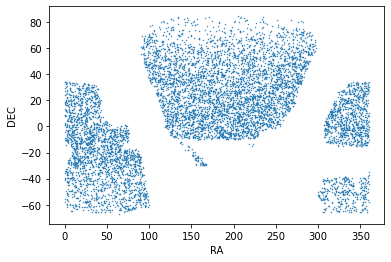

In [4]:
pl.scatter(ra, dec, s=0.2)
pl.xlabel('RA')
pl.ylabel('DEC')

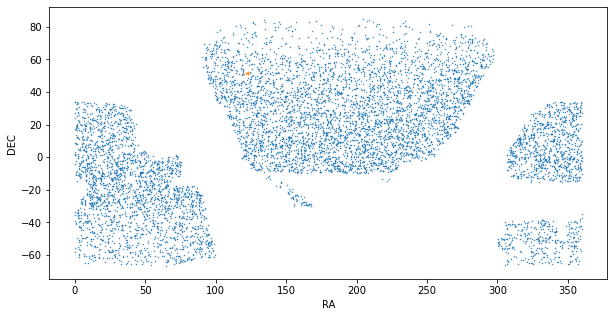

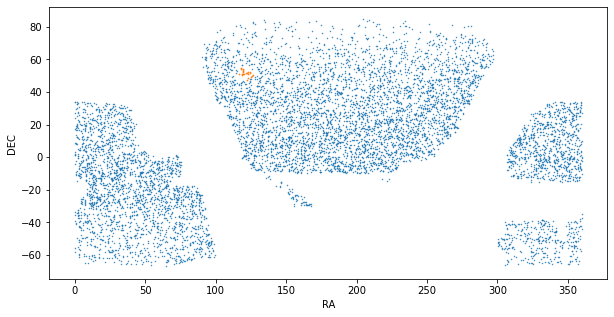

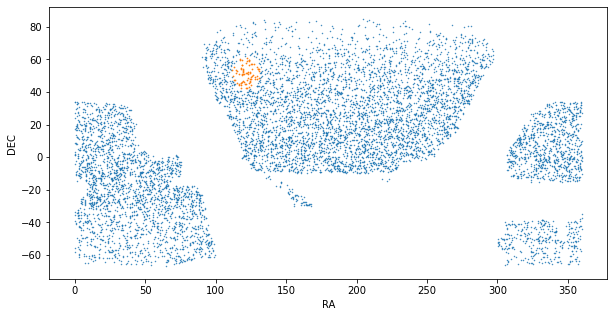

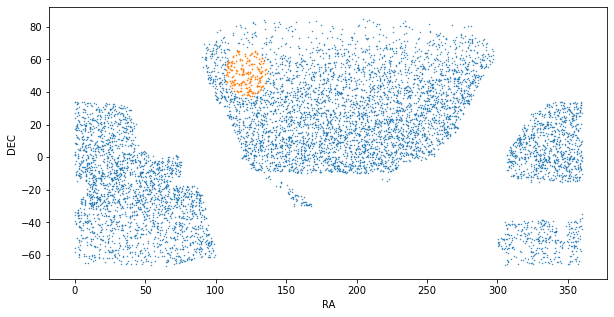

In [5]:
radii = [2,5,10,15]
for r in radii:
    pl.figure(figsize=(10,5))
    ii = (ra - ra[100])**2 + (dec - dec[100])**2 <= r**2
    pl.scatter(ra[~ii], dec[~ii], s=0.2)
    pl.scatter(ra[ii], dec[ii], s=0.5)

    pl.xlabel('RA')
    pl.ylabel('DEC')

In [6]:
%%time
MEAN_E_R = np.zeros(len(radii), object)
MEAN_PHI_R = np.zeros(len(radii), object)

for i, r in enumerate(radii):
    mean_e_temp = []
    mean_phi_temp = []
    for ra_, dec_ in zip(ra,dec):
        ii = (ra - ra_)**2 + (dec - dec_)**2 <= r**2
        mean_e_temp.append(np.mean(data['E'][ii]))
        mean_phi_temp.append(np.mean(data['PHI'][ii]))
    MEAN_E_R[i]   =  mean_e_temp
    MEAN_PHI_R[i] =  mean_phi_temp

CPU times: user 17.8 s, sys: 22.4 ms, total: 17.8 s
Wall time: 17.8 s


In [7]:
new_data = pd.DataFrame( np.c_[data.values, MEAN_E_R[0], MEAN_E_R[1], MEAN_E_R[2], MEAN_E_R[3], MEAN_PHI_R[0], MEAN_PHI_R[1], MEAN_PHI_R[2], MEAN_PHI_R[3]], columns=list(data.keys())+['MEAN_E_R1','MEAN_E_R2','MEAN_E_R3','MEAN_E_R4','MEAN_PHI_R1','MEAN_PHI_R2','MEAN_PHI_R3','MEAN_PHI_R4'])
new_data

,ID,RA,DEC,E1,E2,E,R,BA,PHI,MEAN_E_R1,MEAN_E_R2,MEAN_E_R3,MEAN_E_R4,MEAN_PHI_R1,MEAN_PHI_R2,MEAN_PHI_R3,MEAN_PHI_R4
0,0.0,48.214122,3.364213,-0.085077,-0.032131,0.090942,0.828386,0.833277,-1.390242,0.208941,0.252351,0.250956,0.253095,-0.577564,-0.387596,-0.080152,-0.120970
1,1.0,44.510998,1.065380,0.010665,0.517033,0.517143,0.324374,0.318267,0.775086,0.439744,0.250106,0.255735,0.264900,0.206672,-0.103654,-0.010437,-0.049175
2,2.0,49.431679,3.856688,-0.080267,-0.060285,0.100385,0.649707,0.817546,-1.248707,0.200590,0.222451,0.235282,0.254903,-1.112812,-0.441050,-0.065978,-0.085446
3,3.0,45.885654,2.831595,0.096744,0.249064,0.267193,0.197299,0.578291,0.600153,0.273629,0.270597,0.249211,0.262052,0.302916,-0.202410,-0.054053,-0.068566
4,4.0,46.847398,2.091573,-0.069107,0.300246,0.308096,0.237640,0.528939,0.898513,0.239608,0.268867,0.247287,0.256889,-0.170749,-0.357200,0.009007,-0.106202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,8142.0,113.992916,37.442305,0.024139,-0.053655,0.058835,0.172370,0.888868,-0.574017,0.272700,0.309307,0.333719,0.322841,-0.202916,-0.149887,0.069586,0.053748
8143,8143.0,113.480135,38.755951,0.233196,0.060508,0.240918,0.514936,0.611710,0.126937,0.295289,0.321943,0.344051,0.327156,-0.132466,-0.158187,0.065861,0.080053
8144,8144.0,113.163301,35.963134,0.183573,-0.117248,0.217822,0.267099,0.642277,-0.284196,0.297663,0.295540,0.344622,0.324339,-0.265419,-0.093151,0.121171,0.095937
8145,8145.0,113.140462,36.490842,0.024284,0.428343,0.429031,1.391502,0.399550,0.757082,0.297663,0.302375,0.341629,0.324877,-0.265419,-0.177067,0.089166,0.082581


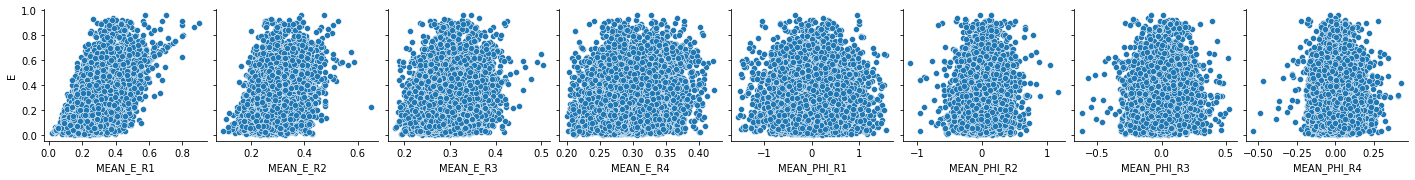

In [8]:
sns.pairplot(new_data, x_vars=['MEAN_E_R1','MEAN_E_R2','MEAN_E_R3','MEAN_E_R4','MEAN_PHI_R1','MEAN_PHI_R2','MEAN_PHI_R3','MEAN_PHI_R4'], y_vars=['E'])

In [9]:
E_vec = np.c_[ new_data['E']*np.cos(new_data['PHI']*np.pi/180), new_data['E']*np.sin(new_data['PHI']*np.pi/180) ]
E_mean_vec_R1 = np.c_[new_data['MEAN_E_R1']*np.cos(new_data['MEAN_PHI_R1']*np.pi/180),  new_data['MEAN_E_R1']*np.sin(new_data['MEAN_PHI_R1']*np.pi/180) ]
E_mean_vec_R2 = np.c_[new_data['MEAN_E_R2']*np.cos(new_data['MEAN_PHI_R2']*np.pi/180),  new_data['MEAN_E_R2']*np.sin(new_data['MEAN_PHI_R2']*np.pi/180) ]
E_mean_vec_R3 = np.c_[new_data['MEAN_E_R3']*np.cos(new_data['MEAN_PHI_R3']*np.pi/180),  new_data['MEAN_E_R3']*np.sin(new_data['MEAN_PHI_R3']*np.pi/180) ]
E_mean_vec_R4 = np.c_[new_data['MEAN_E_R4']*np.cos(new_data['MEAN_PHI_R4']*np.pi/180),  new_data['MEAN_E_R4']*np.sin(new_data['MEAN_PHI_R4']*np.pi/180) ]

In [10]:
np.shape(E_vec), np.shape(E_mean_vec_R1)

((8147, 2), (8147, 2))

1.440003871917595


/tmp/ipykernel_24673/1376427947.py:1: RuntimeWarning: invalid value encountered in arccos
  align_R1 = np.arccos( sum(E_vec.T*E_mean_vec_R1.T)/(np.sqrt(sum(E_vec.T*E_vec.T))*np.sqrt(sum(E_mean_vec_R1.T*E_mean_vec_R1.T))) )*180/np.pi


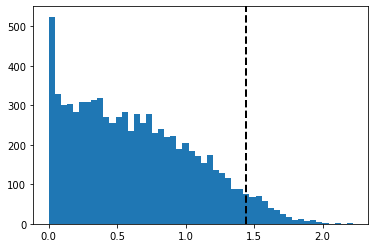

In [11]:
align_R1 = np.arccos( sum(E_vec.T*E_mean_vec_R1.T)/(np.sqrt(sum(E_vec.T*E_vec.T))*np.sqrt(sum(E_mean_vec_R1.T*E_mean_vec_R1.T))) )*180/np.pi
align_R1 = align_R1[~np.isnan(align_R1)]
_ = pl.hist( align_R1, bins=50 )
print(np.percentile(align_R1, 95))
pl.axvline(np.percentile(align_R1, 95), label='95%', color='k', linestyle='dashed', linewidth=2)
pl.show()

1.4992942644004847


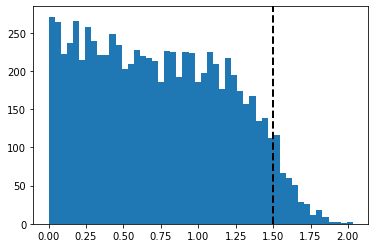

In [12]:
align_R2 = np.arccos( sum(E_vec.T*E_mean_vec_R2.T)/(np.sqrt(sum(E_vec.T*E_vec.T))*np.sqrt(sum(E_mean_vec_R2.T*E_mean_vec_R2.T))) )*180/np.pi
_ = pl.hist( align_R2 , bins=50 )
print(np.percentile(align_R2, 95))
pl.axvline(np.percentile(align_R2, 95), label='95%', color='k', linestyle='dashed', linewidth=2)
pl.show()

1.4846936103508672


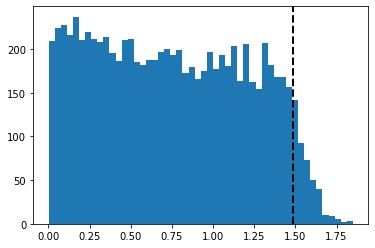

In [13]:
align_R3 = np.arccos( sum(E_vec.T*E_mean_vec_R3.T)/(np.sqrt(sum(E_vec.T*E_vec.T))*np.sqrt(sum(E_mean_vec_R3.T*E_mean_vec_R3.T))) )*180/np.pi
_ = pl.hist(align_R3 , bins=50  )
print(np.percentile(align_R3, 95))
pl.axvline(np.percentile(align_R3, 95), label='95%', color='k', linestyle='dashed', linewidth=2)
pl.show()

1.4844346474426169


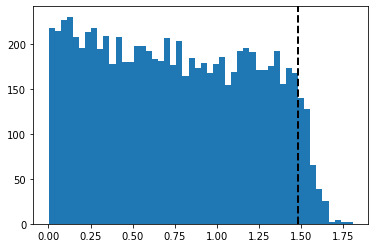

In [14]:
align_R4 = np.arccos( sum(E_vec.T*E_mean_vec_R4.T)/(np.sqrt(sum(E_vec.T*E_vec.T))*np.sqrt(sum(E_mean_vec_R4.T*E_mean_vec_R4.T))) )*180/np.pi
_ = pl.hist( align_R4 , bins=50 )
print(np.percentile(align_R4, 95))
pl.axvline(np.percentile(align_R4, 95), label='95%', color='k', linestyle='dashed', linewidth=2)
pl.show()